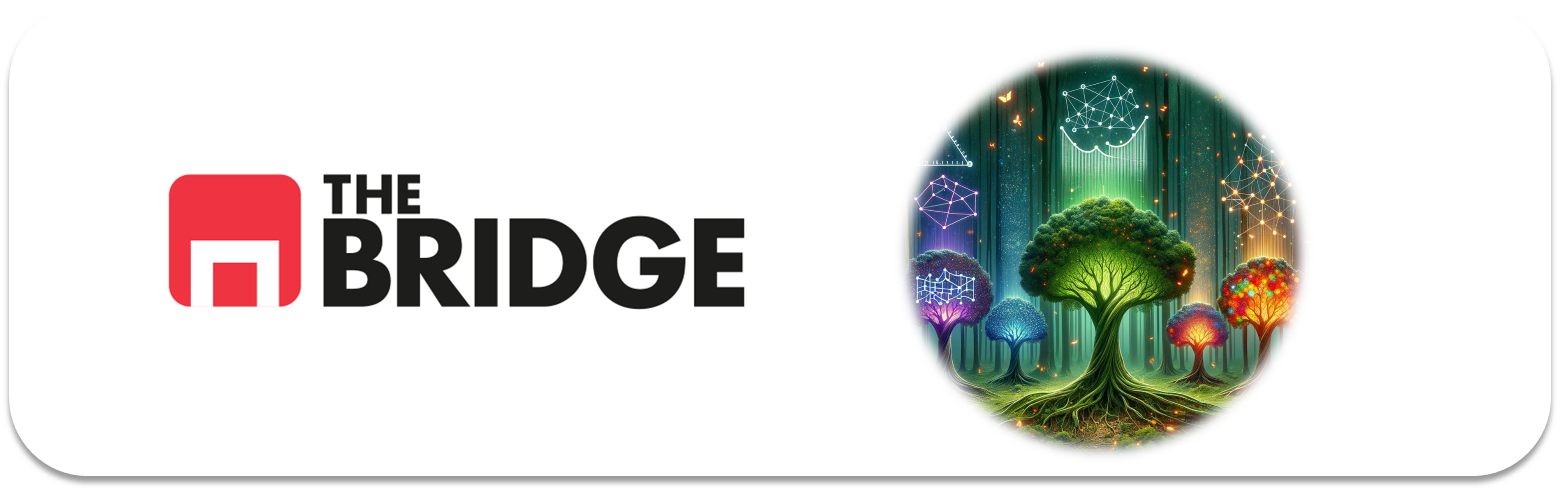

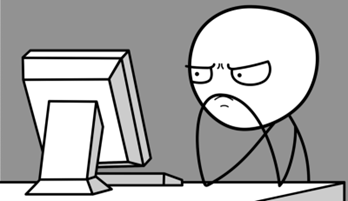

Para ejercitarte y afianzar lo aprendido sobre **Regresion con Árboles de decisión**, completa los siguientes ejercicios. Recuerda que necesitarás datos que están en el directorio data que acompaña al notebook (búscalo en el repositorio de ejercicios)
  
La solución a los mismos las tienes ya, intenta no mirarlos de primeras pero no dejes de hacerlo cuando hayas terminado por si te pudieran aportar.

Este conjunto de ejercicios trabajan sobre un dataset de temperaturas tomados de la ciudad de Seattle. El objetivo es intentar predecir lo mejor posible la máxima temperatura (columna `actual`) que alcanzaremos al día siguiente. Para ello contaremos con temperaturas de los dos días anteriores, históricos de máximas temperaturas y un amigo bastante chapas que te da su predicción del tiempo cada día.

**Resumen de datos**:
* year: 2016 for all data points
* month: number for month of the year
* day: number for day of the year
* week: day of the week as a character string
* temp_2: max temperature 2 days prior
* temp_1: max temperature 1 day prior
* average: historical average max temperature
* actual: max temperature measurement
* friend: your friend’s prediction, a random number between 20 below the average and 20 above the average



### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn


### Ejercicio 1

Importa el csv "temps.csv"

In [2]:
df = pd.read_csv('data/temps.csv')

In [4]:
df

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41
...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,Tues,42,42,45.2,47,41,50,47,47
344,2016,12,28,Wed,42,47,45.3,48,41,49,44,58
345,2016,12,29,Thurs,47,48,45.3,48,43,50,45,65
346,2016,12,30,Fri,48,48,45.4,57,44,46,44,42


In [5]:
df.year.value_counts()


year
2016    348
Name: count, dtype: int64

In [6]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

In [8]:
df

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,date
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29,2016-01-01
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61,2016-01-02
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56,2016-01-03
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53,2016-01-04
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41,2016-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...
343,2016,12,27,Tues,42,42,45.2,47,41,50,47,47,2016-12-27
344,2016,12,28,Wed,42,47,45.3,48,41,49,44,58,2016-12-28
345,2016,12,29,Thurs,47,48,45.3,48,43,50,45,65,2016-12-29
346,2016,12,30,Fri,48,48,45.4,57,44,46,44,42,2016-12-30


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   year            348 non-null    int64         
 1   month           348 non-null    int64         
 2   day             348 non-null    int64         
 3   week            348 non-null    object        
 4   temp_2          348 non-null    int64         
 5   temp_1          348 non-null    int64         
 6   average         348 non-null    float64       
 7   actual          348 non-null    int64         
 8   forecast_noaa   348 non-null    int64         
 9   forecast_acc    348 non-null    int64         
 10  forecast_under  348 non-null    int64         
 11  friend          348 non-null    int64         
 12  date            348 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(10), object(1)
memory usage: 35.5+ KB


### Ejercicio 2

Haz un one-hot encoding de las variables categóricas del dataset

In [15]:
# Primero dividir las variables por tipo, usando la función que programamos en los ejercicios
def card_tipo(df,umbral_categoria = 10, umbral_continua = 30):
    # Primera parte: Preparo el dataset con cardinalidades, % variación cardinalidad, y tipos
    df_temp = pd.DataFrame([df.nunique(), df.nunique()/len(df) * 100, df.dtypes]) # Cardinaliad y porcentaje de variación de cardinalidad
    df_temp = df_temp.T # Como nos da los valores de las columnas en columnas, y quiero que estas sean filas, la traspongo
    df_temp = df_temp.rename(columns = {0: "Card", 1: "%_Card", 2: "Tipo"}) 
    # Cambio el nombre de la transposición anterior para que tengan más sentido, y uso asignación en vez de inplace = True (esto es arbitrario para el tamaño de este dataset)

    # Corrección para cuando solo tengo un valor
    df_temp.loc[df_temp.Card == 1, "%_Card"] = 0.00

    # Creo la columna de sugerenica de tipo de variable, empiezo considerando todas categóricas pero podría haber empezado por cualquiera, siempre que adapte los filtros siguientes de forma correspondiente
    df_temp["tipo_sugerido"] = "Categorica"
    df_temp.loc[df_temp["Card"] == 2, "tipo_sugerido"] = "Binaria"
    df_temp.loc[df_temp["Card"] >= umbral_categoria, "tipo_sugerido"] = "Numerica discreta"
    df_temp.loc[df_temp["%_Card"] >= umbral_continua, "tipo_sugerido"] = "Numerica continua"
    return df_temp

In [18]:
card_tipo(df, 15)


,Card,%_Card,Tipo,tipo_sugerido
year,1,0.0,int64,Categorica
month,12,3.448276,int64,Categorica
day,31,8.908046,int64,Numerica discreta
week,7,2.011494,object,Categorica
temp_2,56,16.091954,int64,Numerica discreta
temp_1,56,16.091954,int64,Numerica discreta
average,243,69.827586,float64,Numerica continua
actual,55,15.804598,int64,Numerica discreta
forecast_noaa,37,10.632184,int64,Numerica discreta
forecast_acc,37,10.632184,int64,Numerica discreta


In [17]:
categorical_columns = ['week', 'month']
df_encoded = pd.get_dummies(df, columns=categorical_columns)

# Mostrar el resultado
print(df_encoded)

     year  day  temp_2  temp_1  average  actual  forecast_noaa  forecast_acc  \
0    2016    1      45      45     45.6      45             43            50   
1    2016    2      44      45     45.7      44             41            50   
2    2016    3      45      44     45.8      41             43            46   
3    2016    4      44      41     45.9      40             44            48   
4    2016    5      41      40     46.0      44             46            46   
..    ...  ...     ...     ...      ...     ...            ...           ...   
343  2016   27      42      42     45.2      47             41            50   
344  2016   28      42      47     45.3      48             41            49   
345  2016   29      47      48     45.3      48             43            50   
346  2016   30      48      48     45.4      57             44            46   
347  2016   31      48      57     45.5      40             42            48   

     forecast_under  friend  ... month_

### Ejercicio 3

Divide en train y test

In [24]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df_encoded, test_size= 0.2, random_state= 42)

In [25]:
df_encoded.columns

Index(['year', 'day', 'temp_2', 'temp_1', 'average', 'actual', 'forecast_noaa',
       'forecast_acc', 'forecast_under', 'friend', 'date', 'week_Fri',
       'week_Mon', 'week_Sat', 'week_Sun', 'week_Thurs', 'week_Tues',
       'week_Wed', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12'],
      dtype='object')

In [76]:
target= 'actual'
features = ['temp_2', 'temp_1', 'average', 'forecast_noaa',
       'forecast_acc', 'forecast_under', 'friend', 'week_Fri',
       'week_Mon', 'week_Sat', 'week_Sun', 'week_Thurs', 'week_Tues',
       'week_Wed', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12']

In [77]:
X_train = train_set[features]
y_train = train_set[target]

In [78]:
X_test = test_set[features]
y_test = test_set[target]

### Ejercicio 4

Instancia un DecisionTreeRegressor de sklearn con hiperparámetros por defecto y entrénalo.

In [79]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42) 

tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

### Ejercicio 5

Calcula su MAE sin usar sklearn.

In [80]:
pred_test = tree_reg.predict(X_test)

In [81]:
def calculate_mae_mape(actual, predicted):
    """
    Calcula el Mean Absolute Error (MAE) entre dos listas o arrays.
    
    Parámetros:
    - actual: lista o array con los valores reales.
    - predicted: lista o array con los valores predichos.
    
    Retorna:
    - mae: el error absoluto medio.
    """
    # Asegurarnos de que ambas listas tienen la misma longitud
    if len(actual) != len(predicted):
        raise ValueError("Las listas 'actual' y 'predicted' deben tener la misma longitud.")
    
    # Calcular la suma de los errores absolutos
    absolute_errors = [abs(a - p) for a, p in zip(actual, predicted)]
    
    # Calcular y retornar el MAE
    mae = sum(absolute_errors) / len(actual)

    percentage_errors = []
    for a, p in zip(actual, predicted):
        if a != 0:
            percentage_errors.append(abs((a - p) / a))
        else:
            raise ValueError("Uno de los valores reales es 0, lo que causa división por cero.")
    
    # Calcular y retornar el MAPE en porcentaje
    mape = (sum(percentage_errors) / len(actual)) * 100
    
    return mae, mape

### Ejercicio 6

Calcula su MAPE sin usar sklearn

In [109]:
print(f"El MAE es: {calculate_mae_mape(y_test, pred_test)[0]}")
print(f"El RMAE es: {np.sqrt(calculate_mae_mape(y_test, pred_test)[0])}")
print(f"El MAPE es: {calculate_mae_mape(y_test, pred_test)[1]}")


El MAE es: 5.357142857142857
El RMAE es: 2.3145502494313788
El MAPE es: 8.57639185588982


### Ejercicio 7

Representa el árbol de decision

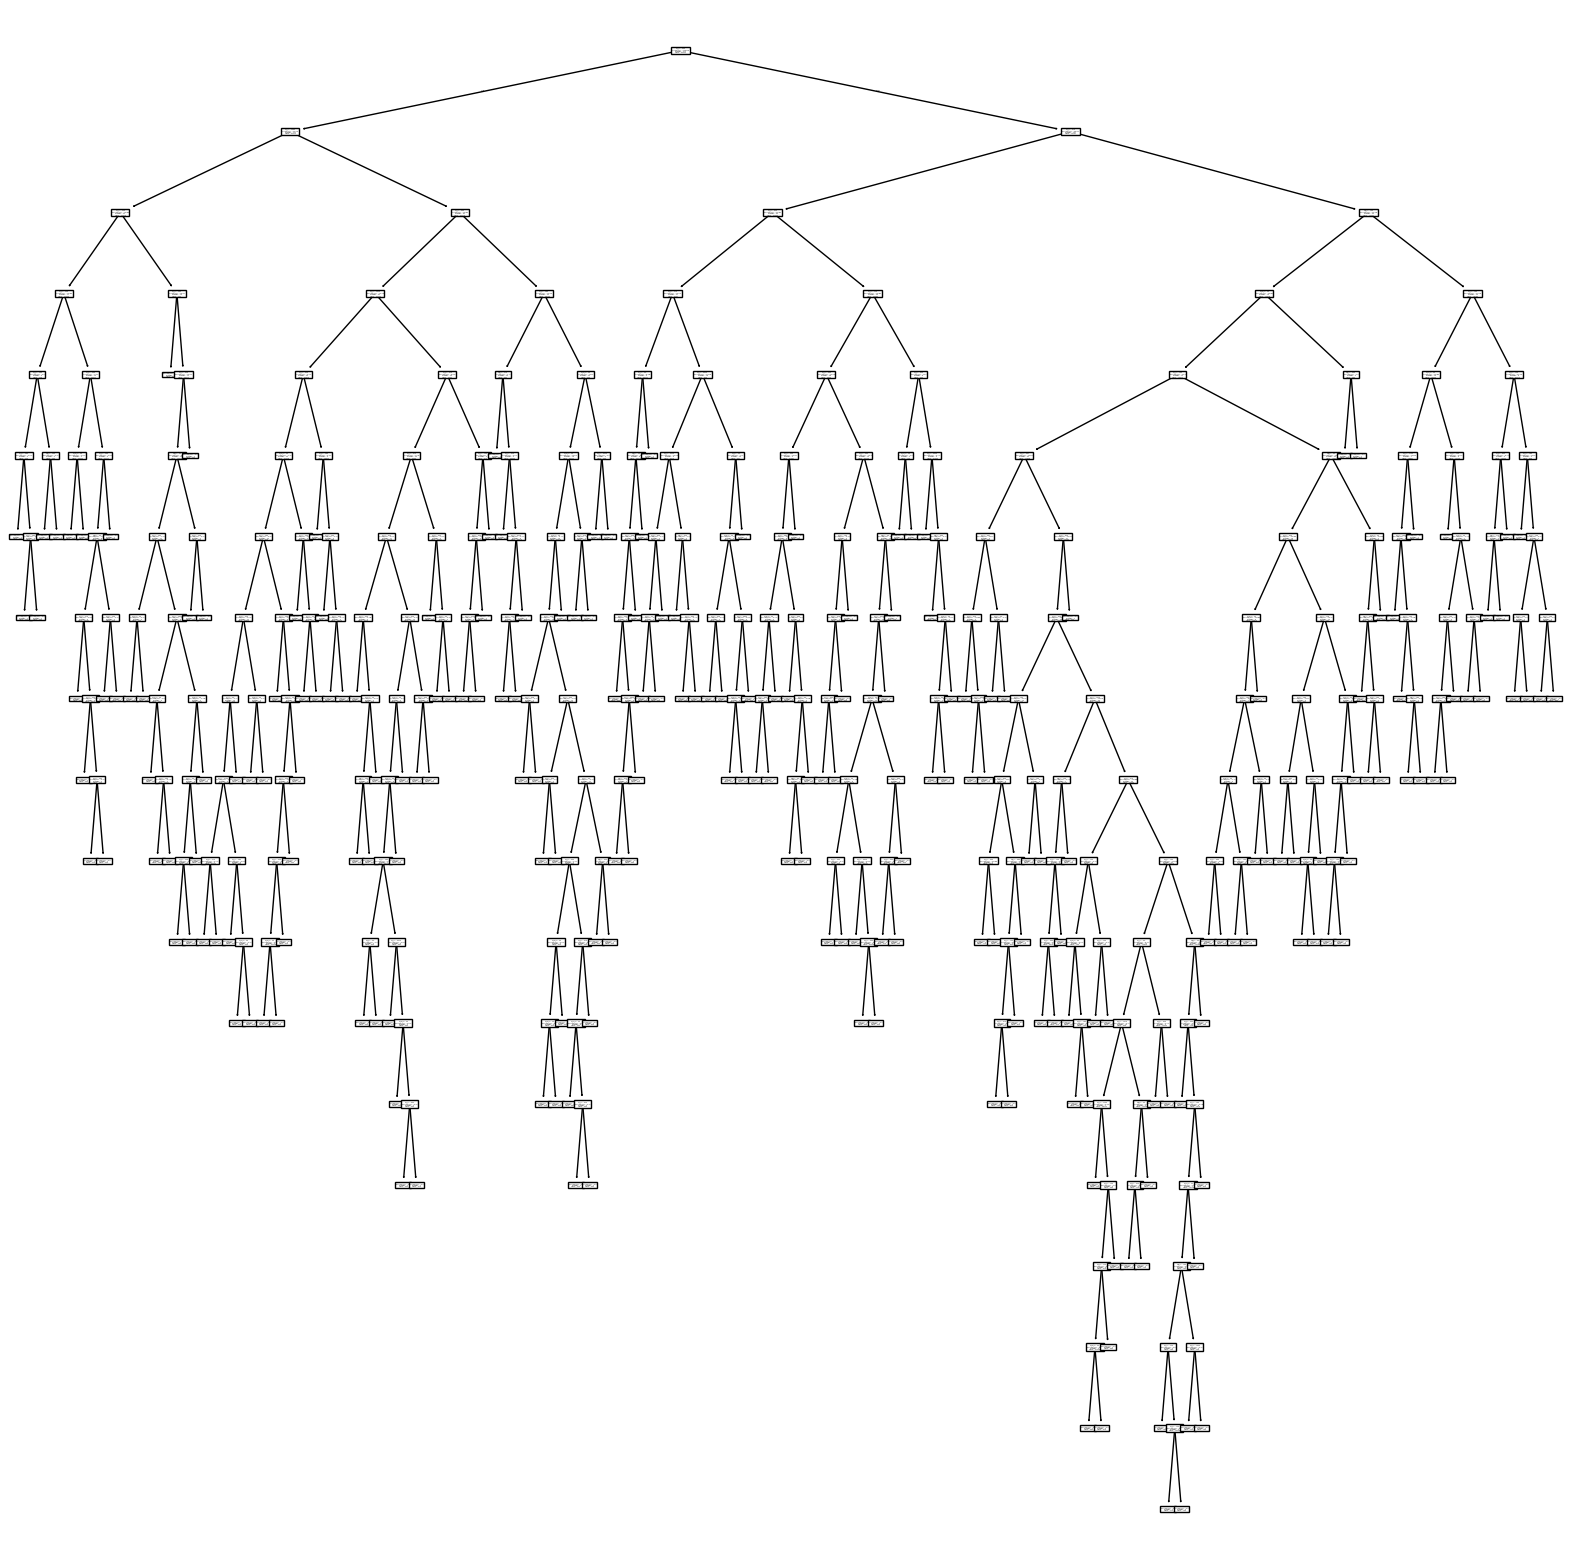

In [83]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,20))
plot_tree(tree_reg);

### Ejercicio 8. 

Instancia un nuevo árbol ahora con max_depth a 3 y vuelve a entrenarlo

In [84]:
from sklearn.tree import DecisionTreeRegressor

tree_reg_3 = DecisionTreeRegressor(max_depth=3,random_state=42) 

tree_reg_3.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [85]:
pred_test_3 = tree_reg_3.predict(X_test)

### Ejercicio 9

Vuelve a calcular MAE y MAPE

In [107]:
print(f"El MAE es: {calculate_mae_mape(y_test, pred_test_3)[0]}")
print(f"El RMAE es: {np.sqrt(calculate_mae_mape(y_test, pred_test_3)[0])}")
print(f"El MAPE es: {calculate_mae_mape(y_test, pred_test_3)[1]}")


El MAE es: 4.4244444942991175
El RMAE es: 2.1034363537552347
El MAPE es: 6.938377135428464


### Ejercicio 10

Vuelve a representar su árbol

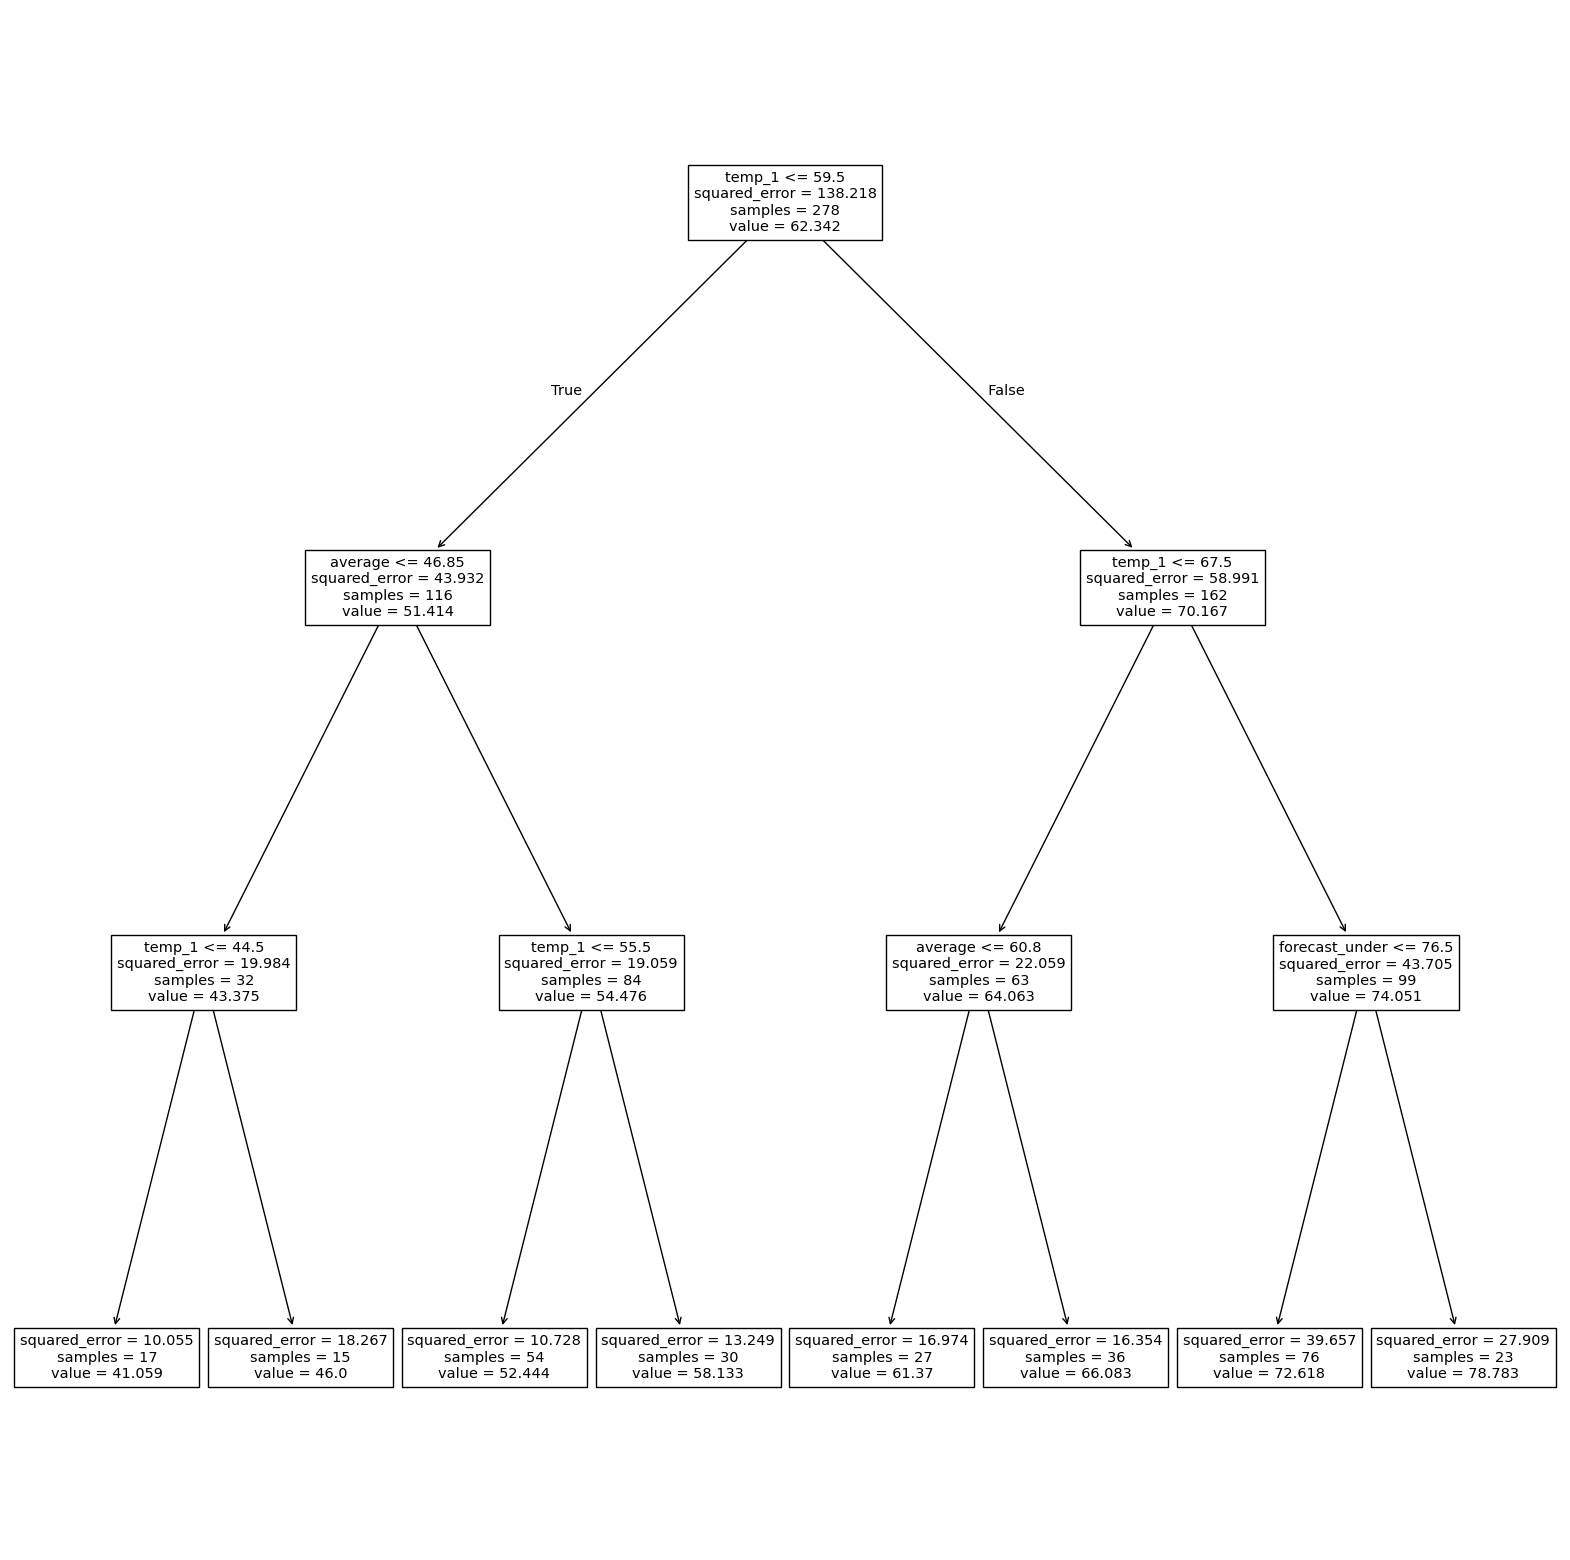

In [87]:
plt.figure(figsize=(20,20))
plot_tree(tree_reg_3, feature_names=features);

### Ejercicio 11

Obten el `feature_importances` de cada variable en el último modelo. Los árboles una vez entrenados tienen un atributo que te lo permite, revisa la documentación si es necesario.

In [105]:
feature_importances = tree_reg.feature_importances_

In [106]:
feature_importances_df = pd.DataFrame(feature_importances, features)
feature_importances_df

,0
temp_2,0.016739
temp_1,0.758448
average,0.104270
forecast_noaa,0.015569
forecast_acc,0.026191
forecast_under,0.019394
friend,0.011324
week_Fri,0.002879
week_Mon,0.010495
week_Sat,0.002378


In [97]:
feature_importances_3 = tree_reg_3.feature_importances_

In [104]:
feature_importances_df3 = pd.DataFrame(feature_importances_3, features)
feature_importances_df3

,0
temp_2,0.000000
temp_1,0.880208
average,0.099022
forecast_noaa,0.000000
forecast_acc,0.000000
forecast_under,0.020771
friend,0.000000
week_Fri,0.000000
week_Mon,0.000000
week_Sat,0.000000
